# Unit 2: Fisheries Collapse Module Overview

This module will focus on examining a crucial global issue and important scientific debate about the state of global fisheries.  In this module we will seek to reproduce some of the most widely cited examples of species collapse ever, and examine the evidence behind an influential and widely cited paper on global fisheries, [Worm et al 2006](http://doi.org/10.1126/science.1132294).  However, rather than use the limited data available to Boris Worm and colleagues in 2006, we will be drawing from the best and most recent stock asssement data available today to see how those patterns have faired.  

In this module we will also begin to master one of the most important concepts in data science: manipulation of tabular data using relational database concepts. Instead of working with independent data.frames, we will be working with a large relational database which contains many different tables of different sizes and shapes, but that all all related to each other through a series of different ids.  



## The Database

We will use data from the RAM Legacy Stock Assessment Database.  In order to better introduce some important emerging technologies, we will be accessing these data directly from a relatively new platform that is now playing a key role in data sharing in machine learning communities, with the memorable name, HuggingFace.  We will be streaming data from <https://huggingface.co/datasets/cboettig/ram_fisheries/tree/main/v4.65>.  We will have more to say about this approach as we progress.



## Researcher Spotlight: Daniel Pauly

Science is done by real people.  There are many influential and colorful characters in the global fisheries debate.  I want to highlight Professor Pauly not just because he is so famous, but as an early believer in Open Science and Data Science, before we had either of those words.  His contributions in making fisheries data more open were ground breaking for their time.  I'm also indebted to Professor Pauly whom I had the privilege to meet when I was a junior scientist who had only recently released one of my first software packages, aimed at making data from FishBase more accessible. Academic researchers are typically defined by scientific publications, not software, so I was shocked that Pauly already knew of my software package, and that he encouraged me to continue developing software.  Even today that is not common advice, but I believed him, and it's probably a good reason I am where I am today.  Scientific textbooks and courses are often critiqued for failing to recognize the contributions of those from minority backgrounds, but as the texts are written on global change ecology, I think none will omit the works for Professor Pauly.




## Science Introduction

Background abbreviated documentary, features many of the leading authors on both sides https://vimeo.com/44104959

In [6]:
import ibis
from ibis import _
import ibis.selectors as s
import seaborn.objects as so

In [7]:
con = ibis.duckdb.connect()
base = "https://huggingface.co/datasets/cboettig/ram_fisheries/tree/main/v4.65"
#area = base + "area.csv"

tsmetrics = con.read_csv("https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/tsmetrics.csv")
timeseries = con.read_csv("https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/timeseries.csv",nullstr = "NA")
stock = con.read_csv("https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/stock.csv")
assessment = con.read_csv("https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/assessment.csv")
area = con.read_csv("https://huggingface.co/datasets/cboettig/ram_fisheries/resolve/main/v4.65/area.csv")

area.head().execute()

,country,areatype,areacode,areaname,alternateareaname,areaid
0,Argentina,CFP,ARG-N,Northern Argentina,NA,Argentina-CFP-ARG-N
1,Argentina,CFP,ARG-S,Southern Argentina,NA,Argentina-CFP-ARG-S
2,Australia,AFMA,CASCADE,Cascade Plateau,NA,Australia-AFMA-CASCADE
3,Australia,AFMA,EAUS,Eastern Australia,NA,Australia-AFMA-EAUS
4,Australia,AFMA,ESE,Eastern half of Southeast Australia,NA,Australia-AFMA-ESE


In [8]:
#pull up tables - 

timeseries.head().execute

<bound method Expr.execute of r0 := DatabaseTable: ibis_read_csv_oepwagmkfvgvhdp76mjt3i5x7i
  assessid  string
  stockid   string
  stocklong string
  tsid      string
  tsyear    int64
  tsvalue   float64

Limit[r0, n=5]>

In [9]:
#made table fish which started with timeseries, and joined the stockid column from the stock table, and the tsid/tsunique column from the tsmetrics table
fish = (timeseries
.join(stock,"stockid")
.rename(tsunique="tsid")
.join(tsmetrics,"tsunique")
)

In [25]:
#We created a new table with all the fish stocks, and filtered them by years (>=1950) and created a new column for collapsed 
allfish = (fish
.filter(_.tsunique == "TCbest-MT")
.group_by(_.stockid,_.tsyear)
.agg(catch = _.tsvalue.mean())
.filter(_.tsyear>=1950)
.group_by(_.stockid)
.mutate(collapsed = _['catch'] < 0.1 * _['catch'].max())

)
allfish.execute()


,stockid,tsyear,catch,collapsed
0,ALSKABSAI,1994,15792.50,False
1,ALSKABSAI,2016,23120.50,False
2,ALSKABSAI,1997,18291.75,False
3,ALSKABSAI,1991,10014.25,False
4,ALSKABSAI,2011,20057.25,False
...,...,...,...,...
46051,WPOLLNSO,1973,939000.00,False
46052,WPOLLNSO,1970,861000.00,False
46053,WPOLLNSO,2007,499750.00,False
46054,WPOLLNSO,1978,739000.00,False


In [34]:
#Created a new column N that defines the aggregate of collapse of species for every year
collapsedtable = allfish.group_by(_.tsyear).agg(collapsed = _.collapsed.sum()/197, n=_.count()  )
collapsedtable.execute()

,tsyear,collapsed,n
0,1950,0.406091,197
1,1959,0.406091,265
2,1971,0.482234,449
3,1972,0.482234,459
4,1981,0.532995,672
...,...,...,...
69,1968,0.421320,409
70,1962,0.446701,326
71,1960,0.467005,314
72,1954,0.436548,237


In [33]:
collapsedtable.filter(_.tsyear == 1950).execute() 

,tsyear,collapsed,n
0,1950,80,197


In [ ]:
a = 8

In [7]:
#created codcatch which filtered by atlantic cod, and selected one the "best" catch value for each row
codcatch = fish.filter(_.commonname == "Atlantic cod", _.tsunique == "TCbest-MT")
#we averaged values that had the same year, area ID, and region
aggcodcatch = codcatch.group_by(_.tsyear, _.areaid, _.region).agg(totalcatch=_.tsvalue.mean())
#we summed values across each region
regioncatch = aggcodcatch.group_by(_.tsyear, _.region).agg(totalcatch = _.totalcatch.sum())
regioncatch.execute()



,tsyear,region,totalcatch
0,1961,Europe non EU,1.221876e+06
1,2007,Europe non EU,6.973701e+05
2,2016,Europe non EU,1.170614e+06
3,2000,Europe non EU,7.087889e+05
4,2009,Europe non EU,7.471464e+05
...,...,...,...
363,1991,US East Coast,6.063133e+04
364,1992,US East Coast,4.262633e+04
365,2003,US East Coast,1.546533e+04
366,1957,European Union,1.811220e+05


In [8]:
codcatch.filter(_.tsyear == 2000, _.areaid == "Canada-DFO-4VsW").execute()

,assessid,stockid,stocklong,tsunique,tsyear,tsvalue,tsn,scientificname,commonname,areaid,...,GRSF_uuid,GRSF_areaid,inmyersdb,myersstockid,state,tscategory,tsshort,tslong,tsunitsshort,tsunitslong
0,DFO-MAR-COD4VsW-1958-2002-PREFONTAINE,COD4VsW,Atlantic cod Eastern Scotian Shelf,TCbest-MT,2000,157.0,164712,Gadus morhua,Atlantic cod,Canada-DFO-4VsW,...,4e12fcb9-141a-3eef-af10-23f19f4e4f11,fao:21.4.V.s;fao:21.4.W,1,COD4VsW,Current,CATCH or LANDINGS,TCbest,"General total Catch (TC then TL, MT units only)",MT,Metric tons


In [9]:
timeseries.filter(_.stockid == "COD1ABCDE").head().execute()

,assessid,stockid,stocklong,tsid,tsyear,tsvalue
0,NWWG-COD1ABCDE-1952-2015-ICESIMP2018,COD1ABCDE,Atlantic cod NAFO 1ABCDE,CdivMEANC-ratio,1952,1.311713
1,NWWG-COD1ABCDE-1952-2015-ICESIMP2018,COD1ABCDE,Atlantic cod NAFO 1ABCDE,CdivMEANC-ratio,1953,2.018021
2,NWWG-COD1ABCDE-1952-2015-ICESIMP2018,COD1ABCDE,Atlantic cod NAFO 1ABCDE,CdivMEANC-ratio,1954,2.993397
3,NWWG-COD1ABCDE-1952-2015-ICESIMP2018,COD1ABCDE,Atlantic cod NAFO 1ABCDE,CdivMEANC-ratio,1955,2.701906
4,NWWG-COD1ABCDE-1952-2015-ICESIMP2018,COD1ABCDE,Atlantic cod NAFO 1ABCDE,CdivMEANC-ratio,1956,3.318523


In [10]:
fish = (timeseries
 .rename(tsunique = "tsid")
 .join(tsmetrics,"tsunique")
 .join(stock, ["stockid", "stocklong"])
 .join(assessment,"assessid")
)

cod_catch = (fish
    .filter(_.tscategory == "CATCH or LANDINGS")
    .filter(_.commonname == "Atlantic cod")
)

cod_catch.group_by(_.tslong, _.tsunique).agg(n = _.count()).order_by(_.n.desc()).execute()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,tslong,tsunique,n
0,Catch divided by mean catch,CdivMEANC-ratio,7442
1,"General total Catch (TC then TL, MT units only)",TCbest-MT,7442
2,Total landings,TL-MT,6278
3,Total catch (i.e. landings + discards. Add lan...,TC-MT,4791
4,Catch or landings that is paired with TAC,Cpair-MT,347
5,Total allowable catch,TAC-MT,311
6,Catch divided by MSY,CdivMSY-ratio,165
7,Recreational catch,RecC-MT,8



# Exercise 1: Investigating the North-Atlantic Cod

Now we are ready to dive into our data. First, We seek to replicate the following figure from the Millennium Ecosystem Assessment Project using the RAM data.

![](https://espm-157.github.io/website-r/img/cod.jpg)


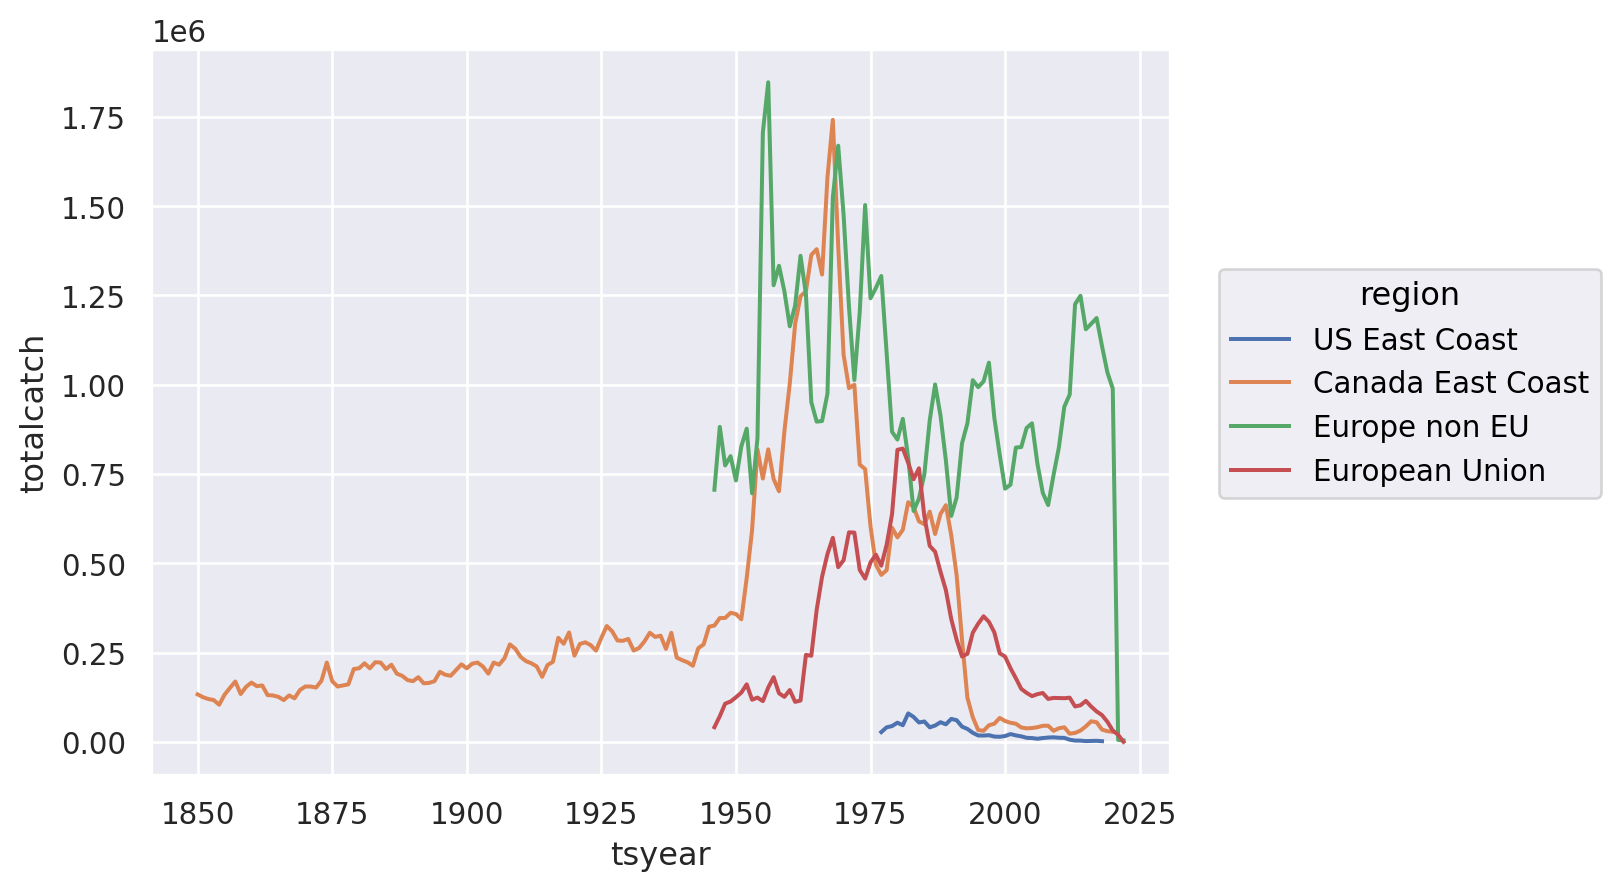

In [11]:
#plotted the total catch by year, seperated by region

so.Plot(regioncatch,x="tsyear", y="totalcatch", color = "region").add(so.Lines())

# Excersise 2: Global Fisheries 

## Stock Collapses

We seek to replicate the temporal trend in stock declines shown in [Worm et al 2006](http://doi.org/10.1126/science.1132294):

![](https://espm-157.github.io/website-r/img/worm2006.jpg)

In [12]:
canadaonly = regioncatch.filter(_.region == "Canada East Coast")
canadaonly.execute()

max_value = canadaonly.totalcatch.max()
max_value.execute()





1741632.0063333334

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt



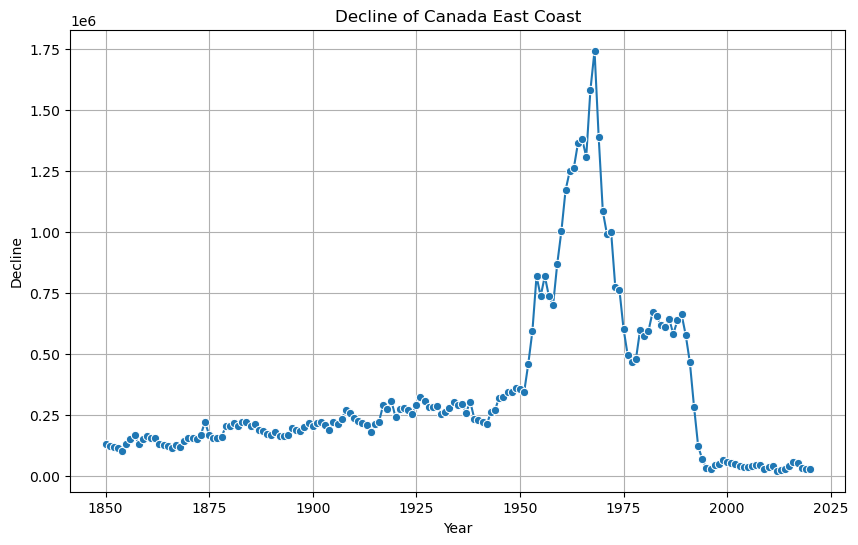

In [20]:
canadaonly = regioncatch.filter(regioncatch['region'] == "Canada East Coast")
# Plot the decline
plt.figure(figsize=(10, 6))
sns.lineplot(x='tsyear', y='totalcatch', data=canadaonly, marker='o')
plt.title('Decline of Canada East Coast')
plt.xlabel('Year')
plt.ylabel('Decline')
plt.grid(True)
plt.show()




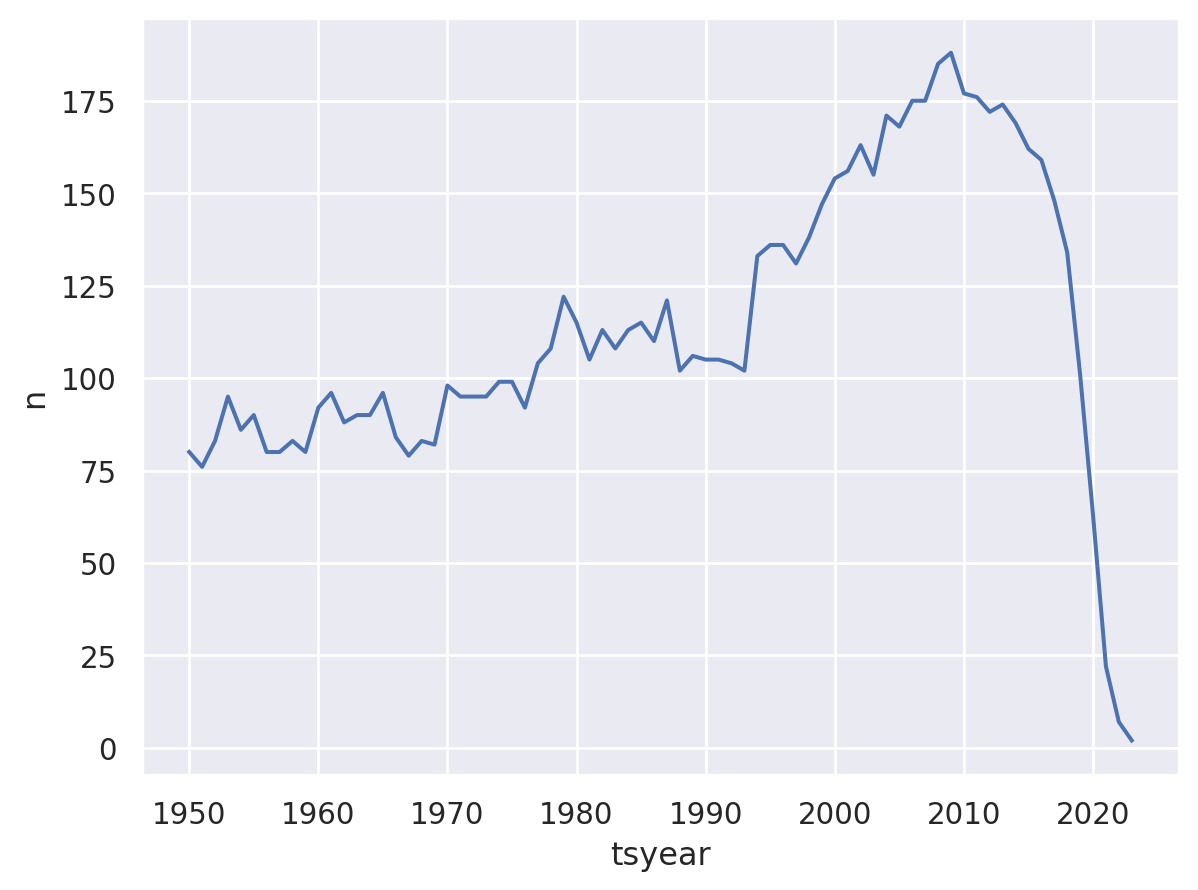

In [31]:
so.Plot(collapsedtable,x="tsyear", y="n").add(so.Lines())